<a href="https://colab.research.google.com/github/yousraBRK/Face_Mask_Detection_RCNN/blob/main/Face_Mask_Detection_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

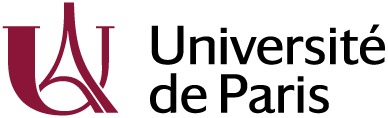
## M2 VMI - TP AD: Object detection using CNNs - Facemasks

Sylvain Lobry, 2020



In this lab we are going to train a model to detect if people are (correctly) wearing face masks. As data, we will use [one of the datasets available on Kaggle](https://www.kaggle.com/andrewmvd/face-mask-detection).

## 1) Loading the data
You can get the data [from kaggle](https://www.kaggle.com/andrewmvd/face-mask-detection) directly, or through my [Google Drive](https://drive.google.com/drive/folders/1oxP0ept0pmOgjl1BbYaUj9Cf_X7FnI2A?usp=sharing). Then, copy it to your drive.

Now, you need to mount your drive in this VM. This is done by executing the following two lines. You will need to authorize google collab to access to your drive (it will ask you to open a link and give you a confirmation code that you will have to copy on the text field bellow).

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Now find the path to your data:

In [ ]:
data_folder = '/content/drive/My Drive/Data/Data' #Change this path!!
root_folder = '/content/drive/My Drive/Data' #Change this path!!

## 2) Understanding the data format
In the data folder, you have 2 sub-folders:


1.   images
2.   annotations

The images are in the png format, and the annotations are in the xml format.

**Question 1:** Open an xml file, and try to understand the information it contains and describe it. From this xml, can you guess what bounding box format is used in this dataset?

Let's parse one XML:

# Answer : 
The xml files contain the coordinates of the rectangles of the people present in the image with an annotation depending on whether the mask is correctly worn or if it is not worn at all, the coordinates are in (xmin, ymin) format on the left angle at the top and (xmax, ymax) on the right angle at the bottom of the bounding box.


In [ ]:
import os
import xml.etree.ElementTree as ET

def get_objects(xml_file):
  annotation = ET.parse(xml_file)
  root = annotation.getroot()

  objects = []
  for obj in root.findall('object'):
    new_object = {'name': obj.find('name').text}
    bbox_tree = obj.find('bndbox')
    new_object['bbox'] = [int(bbox_tree.find('xmin').text),int(bbox_tree.find('ymin').text),int(bbox_tree.find('xmax').text),int(bbox_tree.find('ymax').text)]#TODO: fill the 4 dimensional vector with the coordinates.
    objects.append(new_object)
  return objects

and show the bounding boxes on one image:

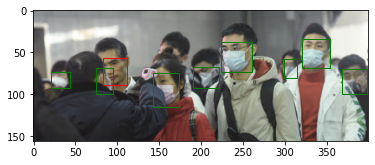

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Color of the bounding boxes (depending on the class)
classes_color = {'with_mask':'g', 'without_mask':'r', 'mask_weared_incorrect':'tab:orange'}
classes_index = {'with_mask':1, 'without_mask':2, 'mask_weared_incorrect':3} #Careful!! 0 is for background!!

def show_bboxes(image, objects):
  fig,ax = plt.subplots(1)
  ax.imshow(image)

  for annotation in objects:
    xmin, ymin, xmax, ymax = annotation['bbox']
    rect = patches.Rectangle((xmin,ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor=classes_color[annotation['name']], facecolor='none')
    ax.add_patch(rect)
  plt.show()

index =1 #TODO: choose a relevant example
objects = get_objects(os.path.join(data_folder, 'annotations', 'maksssksksss' + str(index) + '.xml'))
image = plt.imread(os.path.join(data_folder, 'images', 'maksssksksss' + str(index) + '.png'))
show_bboxes(image, objects)

**Question 2:** We are going to learn from this data. By looking at it, can you find possible biases in it?

## Answer :
The fact that all people are Asian can impact the performance of the model and lead to over-learning.

## 3) Creating the dataset class

Now, we need to create a class derived from pytorch's Dataset class able to understand or data format. Since the datasert is not too big, we can load it entirely in RAM.

In [ ]:
from torch.utils.data import Dataset
import torchvision.transforms as T
from tqdm.notebook import tqdm
from PIL import Image

class FaceMaskDataset(Dataset):
  def __init__(self, img_folder, annotation_folder, indexes, conversion=T.ToTensor()):
    self.conversion = conversion
    
    self.dataset = []
    for index in tqdm(indexes):
      sample = {}
      # Load the image
      sample['image'] = cv2.cvtColor(plt.imread(os.path.join(data_folder, 'images', 'maksssksksss' + str(index) + '.png')),cv2.COLOR_BGR2RGB)
      sample['objects'] = get_objects(os.path.join(data_folder, 'annotations', 'maksssksksss' + str(index) + '.xml'))
      sample['id'] = index
      self.dataset.append(sample)
    
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    target = {'boxes': [], 'labels': []}
    for obj in self.dataset[idx]['objects']:
      target["boxes"].append(obj['bbox'])
      target['labels'].append(classes_index[obj['name']])
      
    target["boxes"] = torch.as_tensor(target["boxes"], dtype=torch.float32)
    target["labels"] = torch.as_tensor(target['labels'], dtype=torch.int64)
    target["image_id"] = torch.tensor([self.dataset[idx]['id']])

    img = self.dataset[idx]['image']
    if self.conversion is not None:
      img = self.conversion(img)
    return img, target

And we can create the datasets.

**Question 3:** What is the total number of samples that we have? Does that seem sufficient to train a model? What strategy could we use for training? 

# Answer :
Our dataset is made up of 853 data which is not enough to properly train a model, we can remedy this by increasing the data.

We have divided the dataset into:
80% Train
10% Validation
20% Test

To keep as much data as possible for training

In [ ]:
import random
import torch
import torchvision
import PIL
import cv2

train_split_percentage = 0.70 #TODO: Choose
val_split_percentage = 0.10 #TODO: Choose
test_split_percentage = 0.20 #TODO: Choose
size_of_the_dataset = 853#TODO

indexes = list(range(size_of_the_dataset))
random.shuffle(indexes)

train_indexes = indexes[:int(train_split_percentage*len(indexes))]
val_indexes = indexes[int(train_split_percentage*len(indexes)):int((train_split_percentage + val_split_percentage)*len(indexes))]
test_indexes = indexes[int((train_split_percentage + val_split_percentage)*len(indexes)):]

print(f"Effective train split = {len(train_indexes)/len(indexes)*100}%")
print(f"Effective val split = {len(val_indexes)/len(indexes)*100}%")
print(f"Effective test split = {len(test_indexes)/len(indexes)*100}%", flush=True)

# From https://github.com/pytorch/vision/blob/ce342580f3ae3f937fa5389c48b82a827b4804df/references/detection/utils.py#L235
def collate_fn(batch):
    return tuple(zip(*batch))




def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    #TODO: potentially add data augmentation
    
    if train:
     transforms.append(T.RandomHorizontalFlip(0.5))
     
    return T.Compose(transforms)
   
    


batch_size = 2
print("Loading training set")
train_dataset = FaceMaskDataset(os.path.join(data_folder, 'images'), os.path.join(data_folder, 'annotations'), train_indexes, conversion=get_transform(True))
print("Loading validation set")
val_dataset = FaceMaskDataset(os.path.join(data_folder, 'images'), os.path.join(data_folder, 'annotations'), val_indexes, conversion=get_transform(False))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

Effective train split = 69.98827667057445%
Effective val split = 9.964830011723329%
Effective test split = 20.046893317702228%
Loading training set



Loading validation set


One thing which is always important is to check the data. At the sample size, we have already seen how to check that we understood the data format, and checked a few samples for corectness. At a larger scale, it is often a good idea to check the labels' distribution.

**Question 4:** Propose and implement a methodology to check the labels' distribution. Discuss your findings.

## 4) Defining the model

For this project, we propose to take a pre-trained Faster R-CNN.

Faster R-CNN is an extension of R-CNN seen during the lecture. Conceptually, both methods are very similar. The main improvements of Faster R-CNN is to share convolutional features between the region proposal part and the actual object detection part. To know more, you can read [the original article](https://arxiv.org/pdf/1506.01497.pdf).

This network has been pre-trained on [MS-COCO](https://cocodataset.org/#home), which is a classical large-scale object detection dataset.


Note that the incorrectly worn mask annotation rate is low compared to other rates, which can unbalance the data and impact the performance of the model. Adding data from people not wearing a mask correctly would be preferable.

with_mask: 369
without_mask: 292
mask_weared_incorrect: 245


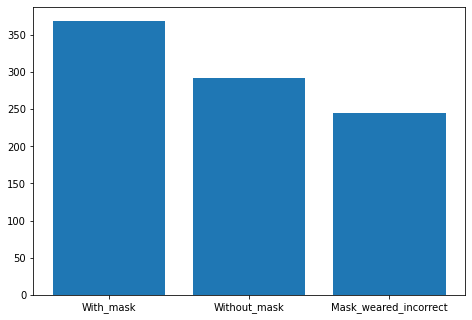

In [ ]:
import matplotlib.pyplot as plt

with_mask=0 #1
without_mask=0  #2
mask_weared_incorrect =0 #3

for index in range(len(train_dataset)):  #loop on each data of the trainset
  tpl=train_dataset.__getitem__(index)
  target=tpl[1]  # Target = target
  labels=target['labels']
  for label in range(len(labels)):   #loop on the labels of the data
    if(label == torch.tensor(1)):
      with_mask+=1
    elif (label == torch.tensor(2)):
      without_mask+=1
    elif (label == torch.tensor(3)):
       mask_weared_incorrect+=1

print ("with_mask: "+ str(with_mask))
print ("without_mask: "+ str(without_mask))
print ("mask_weared_incorrect: "+ str(mask_weared_incorrect))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
wmc = ['With_mask', 'Without_mask', 'Mask_weared_incorrect']
values = [with_mask,without_mask,mask_weared_incorrect]
ax.bar(wmc,values)
plt.show()
  
  

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#load Faster R-CNN pre-trained on COCO dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#Change the classifier head with a new one:
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 4 #(3 + background)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


## 5) Training

Now that we have both the architecture and the data, we can train our model.

You should enable GPU in your collab at this point. To do so go to runtime -> Change runtime type -> Hardware accelerator and select "GPU";

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = model.to(device)

Using device: cuda


We can now define the training loop.

**Question 5:** How did you choose your hyper-parameters?

In [ ]:
size_train_dataset=train_dataset.__len__()
size_val_dataset=val_dataset.__len__()

Starting epoch 0



Starting epoch 1


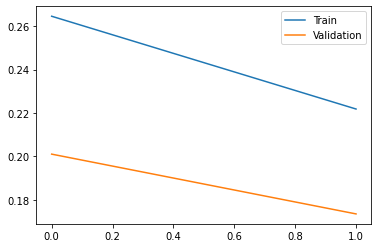

Starting epoch 2


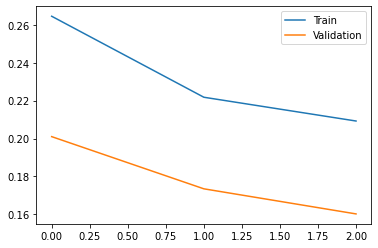

Starting epoch 3


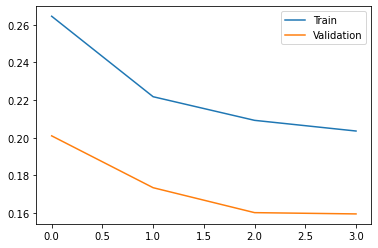

Starting epoch 4


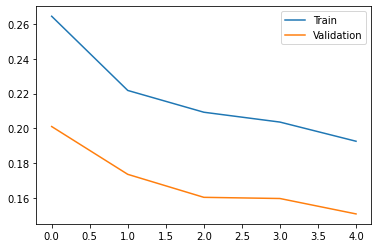

Starting epoch 5


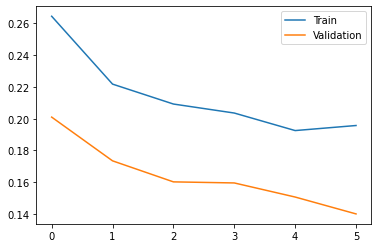

Starting epoch 6


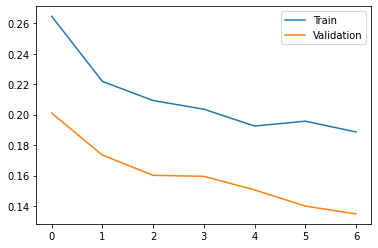

Starting epoch 7


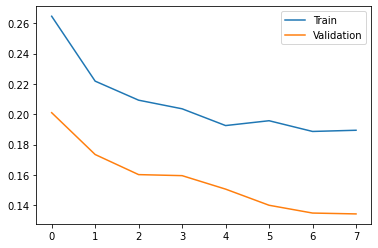

Starting epoch 8


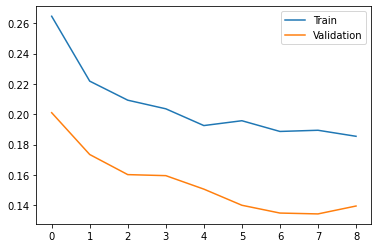

Starting epoch 9


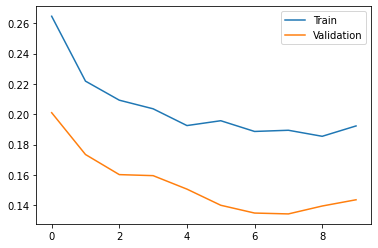

Starting epoch 10


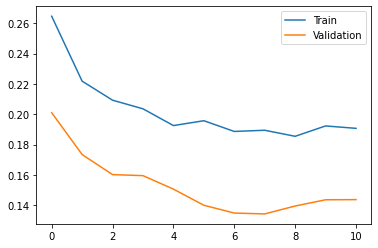

Starting epoch 11


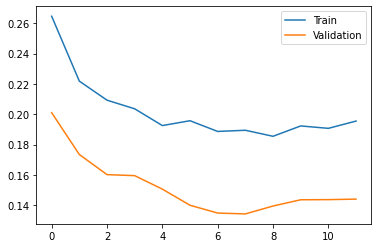

Starting epoch 12


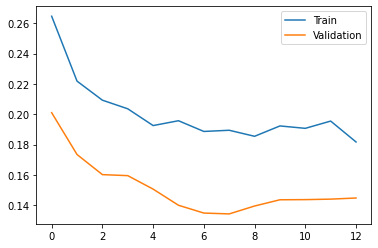

Starting epoch 13


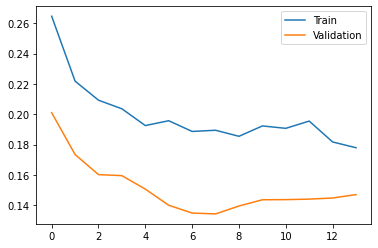

Starting epoch 14


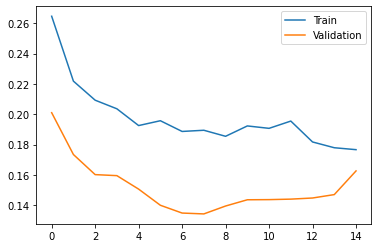

In [ ]:
number_epochs = 15 
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9)

train_loss = []
val_loss = []

for epoch in range(number_epochs):
  print(f"Starting epoch {epoch}")

  if epoch > 0:
    plt.figure()

  model.train()
  train_loss.append(0)
  for images, labels in tqdm(train_loader):
    images = list(image.to(device) for image in images)
    labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

    loss_dict = model(images, labels)

    losses = sum(loss for loss in loss_dict.values())
    optimizer.zero_grad()
    losses.backward()
    optimizer.step() 

    train_loss[epoch] += losses.cpu().data
  train_loss[epoch] /= len(train_dataset)

  if epoch > 0:
    train_plt, = plt.plot(train_loss, label = 'Train')

  val_loss.append(0)
  with torch.no_grad():
    #TODO: compute the loss on the validation set and fill val_loss[epoch]
    for images, labels in tqdm(val_loader):
      images = list(image.to(device) for image in images)
      labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

      loss_dict = model(images, labels)

      losses = sum(loss for loss in loss_dict.values())
      #optimizer.zero_grad()
      #losses.backward()
      #optimizer.step() 

      val_loss[epoch] += losses.cpu().data
    val_loss[epoch] /= len(val_dataset)
  if epoch > 0:
    val_plt, = plt.plot(val_loss, label = 'Validation')
    plt.legend(handles=[train_plt, val_plt])
    plt.show()

  torch.save(model.state_dict(), os.path.join(root_folder, 'model_epoch' + str(epoch) + '.pt'))



## 6) Evaluate the model
First, we need to load the test set:

In [ ]:
print("Loading test set")
test_dataset = FaceMaskDataset(os.path.join(data_folder, 'images'), os.path.join(data_folder, 'annotations'), test_indexes, conversion=get_transform(False))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
test_loss = 0

Loading test set


In [ ]:

with torch.no_grad():

  for images, labels in tqdm(test_loader):
    images = list(image.to(device) for image in images)
    labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

    loss_dict = model(images, labels)

    losses = sum(loss for loss in loss_dict.values())

    test_loss += losses.cpu().data

test_loss /= len(test_dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))


**TODO** Now you need to re-use what you have seen before to do the evaluation (both with losses and classical metrics). You need to discuss it.

Good luck!